# Show graphs of Beacon Populations

See the README.md for setup.

NB: This notebook is unreliable unless cells are run one at a time.

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import matplotlib.ticker
import datetime
import collections
import pickle
import time
# Depends on: pip install --upgrade google-cloud-bigquery
from google.cloud import bigquery

# Some matplotlib features are version dependent.
assert(matplotlib.__version__ >= '2.1.2')
print "Done"

Done


# Global flags

Invoke cell individually or reorder them to change defaults

In [2]:
EndDate = '2018-05-13'
LastNew = '2017-05-13'  # Beacons that start after this date are not included
project = 'mlab-sandbox'
dataset_id = 'mattmathis'

In [3]:
# Skip slow/expensive queries
DoQueries=False
# Force queries
DoQueries=True
# Enable interactive figures that pan and zoom
interactive = True
# Enables figures to load inline in the browser and saved (github etc).
interactive = False
# Disable plots for the paper
DoPaper = False

In [4]:
def setupmatplotlib(force=None):
    global interactive
    if force == 'inline':
        %matplotlib inline
        return
    elif force == 'interactive':
        %matplotlib
        return
    elif force is not None:
        print 'Unknown option, using default'
    if interactive:
        print 'default interactive'
        %matplotlib
        return
    else:
        print 'default inline'
        %matplotlib inline
        return
setupmatplotlib()

default inline


In [5]:
# BigQuery interface
def expand_query(query, **kwargs):
    """expand_query: expands nested {parameter} substitutions.
    Stashes forensic output in globals.
    """
    global DebugQuery # For pasting into BQ, after the fact
    global NumberedQuery # For grocking BQ error line numbers.
    global DefaultArgs # To ignore some 

    # Only allow argument substitution 4 levels deep, because
    # accidental infinite recursion risks crashing the notebook.
    args = DefaultArgs.copy()
    args.update(kwargs)
    query=query.format(**args)
    query=query.format(**args)
    query=query.format(**args)
    query=query.format(**args)
    if '{' in query:
        raise "Unexpanded substitutions"
    
    # Leave crumbs incase we need a postmortem
    DebugQuery = query
    NumberedQuery = ""
    for i, l in enumerate(query.split('\n')):
          NumberedQuery += "%3d %s\n"%(i, l)

    return query

def run_query(query, project=project, otherindex=None, timeindex='partition_date', **kwargs):
    """ run_query
        Accepts nested {parameter} substitutions.
        
        Stashes forensic output in globals.
    """
    global NumberedQuery
    query=expand_query(query,  **kwargs)

    # do the work
    client = bigquery.Client(project=project)
    job = client.query(query)  # All errors are delayed

    # Marshal the results, catching async errors
    try:
        results = collections.defaultdict(list)
        for row in job.result(timeout=300):
            for key in row.keys():
                results[key].append(row.get(key)) 
    except:
        print NumberedQuery
        raise

    if otherindex:
        return pd.DataFrame(results, index=results[timeined])
    if timeindex:
        return pd.DataFrame(results, index=pd.DatetimeIndex(results[timeindex]))
    # set timeindex=None to force a raw DataFrame
    return pd.DataFrame(results)

def write_query_table(query, otable,
                      project=project,
                      dataset_id=dataset_id,
                      **kwargs):
    """ write_query_table
        Accepts nested {parameter} substitutions.
        
        Stashes forensic output in globals.
    """
    global NumberedQuery
    query=expand_query(query,  **kwargs)

    # do the work
    client = bigquery.Client(project=project)
    job_config = bigquery.QueryJobConfig()
    table_ref = client.dataset(dataset_id).table(otable)
    job_config.destination = table_ref
    job_config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE
    job = client.query(query, location='US', job_config=job_config)

    # Marshal the results, catching async errors
    try:
        res = job.result()  # Get the first row to make sure it starts
        while not job.done():
            print 'tick'
            time.sleep(5)
        assert job.state == 'DONE'
    except:
        print "Query Errored"
        print NumberedQuery
        raise
    print "Query completed"
    return

# test code
if False:
    testQ="""
    SELECT *
    FROM `{dateset_id}.master_annotations`
    """
    write_query_table(testQ, otable='test_results2')

print "Done"

Done


In [6]:
# Query the list of beacons
BeaconQ ="""
SELECT
  {beacon_fields}
FROM
  `{dataset_id}.master_annotations`
WHERE
  clientIP NOT IN (
    '45.56.98.222',
    '64.9.225.99',
    '64.9.225.190' ) # exclude eb, etc
    {beacon_where}
"""
DefaultArgs = {
    'beacon_where':'',
    'beacon_fields':'clientIP',
    'dataset_id':dataset_id 
}
print "Done"

Done


In [7]:
# Useful for exploring the data
if False:
    %time all_beacons = run_query(BeaconQ, timeindex=None)

In [8]:
# Fetch master beacons into a local DataFrame
# Note that this is 1.5M rows by 26 columns, and may take a long time on some networks
if True:
    %time all_beacon_data = run_query(BeaconQ, beacon_fields='*', timeindex=None)
print "Done"

CPU times: user 4min 52s, sys: 8.8 s, total: 5min 1s
Wall time: 10min 19s
Done


In [9]:
print all_beacon_data.shape
memory = all_beacon_data.memory_usage(deep=True)
print 'Total memory (MB):', memory.sum()/1000000
print memory


(1555329, 26)
Total memory (MB): 774
Index                              72
clientIP                    174392904
dailymax                     12442632
series_average_download      12442632
series_average_upload        12442632
series_count                 12442632
series_download_bytes        12442632
series_download_duration     12442632
series_downloads             12442632
series_elapsed_days          12442632
series_end                   12442632
series_end_asc               12442632
series_interval_hours        12442632
series_metro_details        301560528
series_num_BTWebClient       12442632
series_num_Chrome            12442632
series_num_Firefox           12442632
series_num_IE                12442632
series_num_cli               12442632
series_num_confine           12442632
series_num_metros            12442632
series_num_web100clt         12442632
series_start                 12442632
series_start_asc             12442632
series_upload_bytes          12442632
series_upload

Done


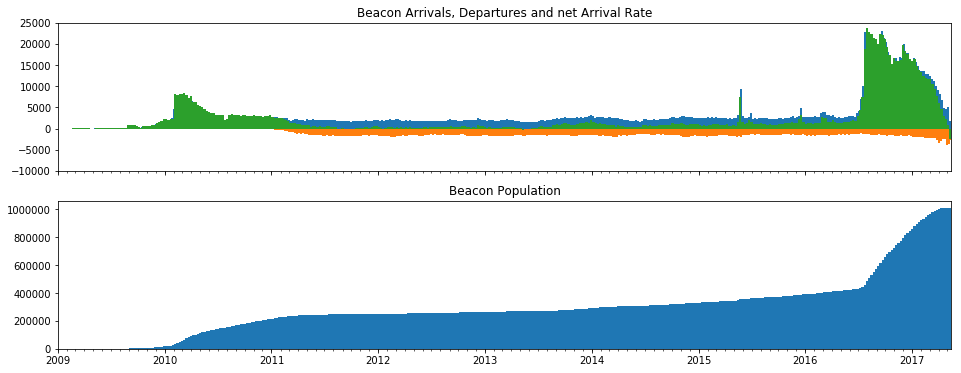

In [10]:
# Non interactive plotting for the paper.
# This version places more attention on the art work
def paper_beacon_pop(data, ofile=None, title=None, xlim=None, figsize=(16, 6)):

    fig, axes = plt.subplots(nrows=2, ncols=1, squeeze=False, sharex=True, figsize=figsize)
   
    ax0 = axes[0][0]
    ax1 = ax0
    ax2 = axes[1][0]
    bins = 436  # Weeks between 2009-01-01 and 2017-05-13
    
    ax0.xaxis.set_major_locator(matplotlib.dates.YearLocator())
    ax0.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
    ax0.xaxis.set_minor_locator(matplotlib.dates.MonthLocator())
    ax0.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter(''))
       
    

    starts = dates.epoch2num(data['series_start'])
    ends = dates.epoch2num(data['series_end'])   
    plusOne = [1 for i in range(len(starts))]
    minusOne = [-1 for i in range(len(ends))]
    times = np.append(starts, ends)
    weights = np.append(plusOne,minusOne)

    ax0.set_title('Beacon Arrivals, Departures and net Arrival Rate')
    ax0.hist(starts, cumulative=False, normed=False, bins=bins)
    ax0.hist(ends, weights=minusOne, cumulative=False, normed=False, bins=bins)
    ax0.set_ylim(-10000, 25000)

#    ax1.set_title('Net Arrivals and Departures')
    ax1.hist(times, weights=weights, cumulative=False, bins=bins)
#    ax1.set_ylim(0, 35000)

    ax2.set_title('Beacon Population')
    ax2.hist(times, weights=plusOne+minusOne, cumulative=True, bins=bins)

    #    ax0.legend()
    
    if xlim is not None:
        ax0.set_xlim(xlim)
    if title and not ofile:
        fig.suptitle(title, y='0.97', fontsize=14)
    if ofile:
        fig.savefig(ofile, dpi=100)
    else:
        plt.show()
    plt.close()
print 'Done'
if True:
    paper_beacon_pop(all_beacon_data, xlim=pd.DatetimeIndex(['2009-01-01',LastNew]))

    
if DoPaper:
    paper_beacon_pop(all_beacon_data, ofile='../paper/Beacons.png',figsize=(6,4),
                     xlim=pd.DatetimeIndex(['2009-01-01',LastNew]))
    print 'Paper Done'